In [1]:
# Data Analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Neural Network Model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint

# Evaluation
from sklearn.metrics import confusion_matrix, classification_report

2022-08-13 06:11:42.879945: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-13 06:11:42.879995: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# pip install scikit-learn

In [3]:
# pip install seaborn
# pip install scikit-learn
# pip install scikit-learn

In [4]:
train_generator = ImageDataGenerator(rotation_range = 360,
                                     width_shift_range = 0.05,
                                     height_shift_range = 0.05,
                                     shear_range = 0.05,
                                     zoom_range = 0.05,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     brightness_range = [0.75, 1.25],
                                     rescale = 1./255,
                                     validation_split = 0.2)

In [5]:
IMAGE_DIR = "Dataset/casting_data/"
IMAGE_SIZE = (225, 225)
BATCH_SIZE = 64
SEED_NUMBER = 123

gen_args = dict(target_size = IMAGE_SIZE,
                color_mode = "grayscale",
                batch_size = BATCH_SIZE,
                class_mode = "binary",
                classes = {"o": 0, "d": 1},
                shuffle = True,
                seed = SEED_NUMBER)

train_dataset = train_generator.flow_from_directory(directory = IMAGE_DIR + "train",
                                                    subset = "training", **gen_args)
validation_dataset = train_generator.flow_from_directory(directory = IMAGE_DIR + "train",
                                                         subset = "validation", **gen_args)

Found 112 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


In [6]:
test_generator = ImageDataGenerator(rescale = 1./255)
test_dataset = test_generator.flow_from_directory(directory = IMAGE_DIR + "test",**gen_args)

Found 100 images belonging to 2 classes.


In [7]:
image_data = [{"data": typ,
               "class": name.split('/')[0],
               "filename": name.split('/')[1]}
              for dataset, typ in zip([train_dataset, validation_dataset, test_dataset], ["train", "validation", "test"])
              for name in dataset.filenames]
image_df = pd.DataFrame(image_data)
data_crosstab = pd.crosstab(index = image_df["data"],
                            columns = image_df["class"],
                            margins = True,
                            margins_name = "Total")
data_crosstab

class,d,o,Total
data,,,
test,50,50,100
train,56,56,112
validation,14,14,28
Total,120,120,240


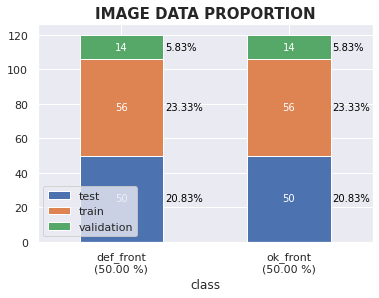

In [8]:
total_image = data_crosstab.iloc[-1,-1]
ax = data_crosstab.iloc[:-1,:-1].T.plot(kind = "bar", stacked = True, rot = 0)

percent_val = []

for rect in ax.patches:
    height = rect.get_height()
    width = rect.get_width()
    percent = 100*height/total_image

    ax.text(rect.get_x() + width - 0.25, 
            rect.get_y() + height/2, 
            int(height), 
            ha = 'center',
            va = 'center',
            color = "white",
            fontsize = 10)
    
    ax.text(rect.get_x() + width + 0.01, 
            rect.get_y() + height/2, 
            "{:.2f}%".format(percent), 
            ha = 'left',
            va = 'center',
            color = "black",
            fontsize = 10)
    
    percent_val.append(percent)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles = handles, labels = labels)

percent_def = sum(percent_val[::2])
ax.set_xticklabels(["def_front\n({:.2f} %)".format(percent_def), "ok_front\n({:.2f} %)".format(100-percent_def)])
plt.title("IMAGE DATA PROPORTION", fontsize = 15, fontweight = "bold")
plt.show()

In [9]:
mapping_class = {0: "ok", 1: "defect"}
mapping_class

{0: 'ok', 1: 'defect'}

In [10]:
def visualizeImageBatch(dataset, title):
    images, labels = next(iter(dataset))
    images = images.reshape(BATCH_SIZE, *IMAGE_SIZE)
    fig, axes = plt.subplots(8, 8, figsize=(16,16))

    for ax, img, label in zip(axes.flat, images, labels):
        ax.imshow(img, cmap = "gray")
        ax.axis("off")
        ax.set_title(mapping_class[label], size = 20)

    plt.tight_layout()
    fig.suptitle(title, size = 30, y = 1.05, fontweight = "bold")
    plt.show()
    
    return images

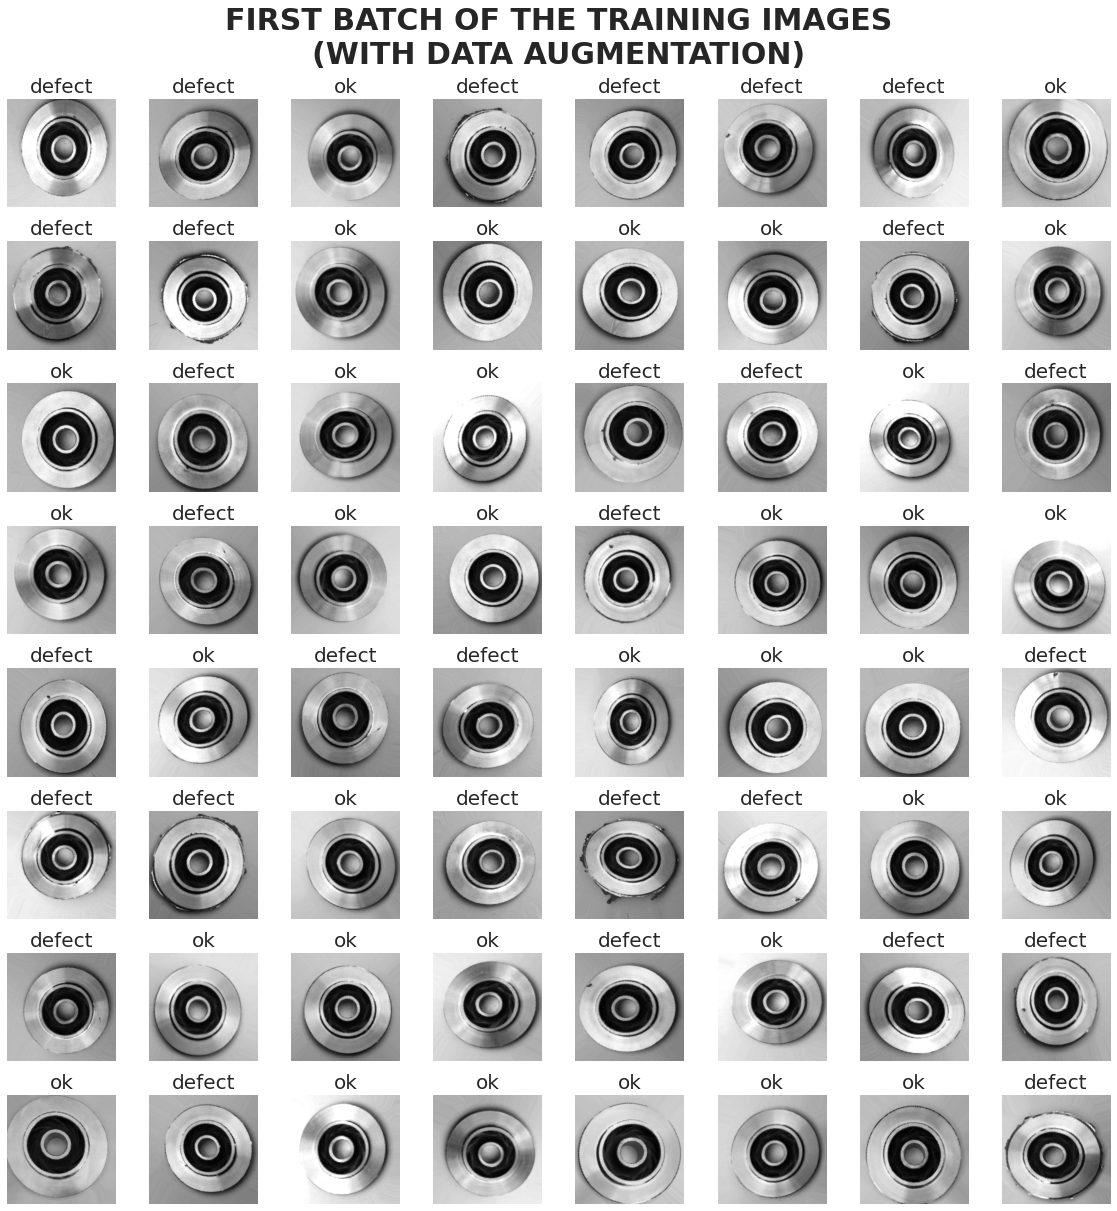

In [11]:
train_images = visualizeImageBatch(train_dataset, "FIRST BATCH OF THE TRAINING IMAGES\n(WITH DATA AUGMENTATION)")

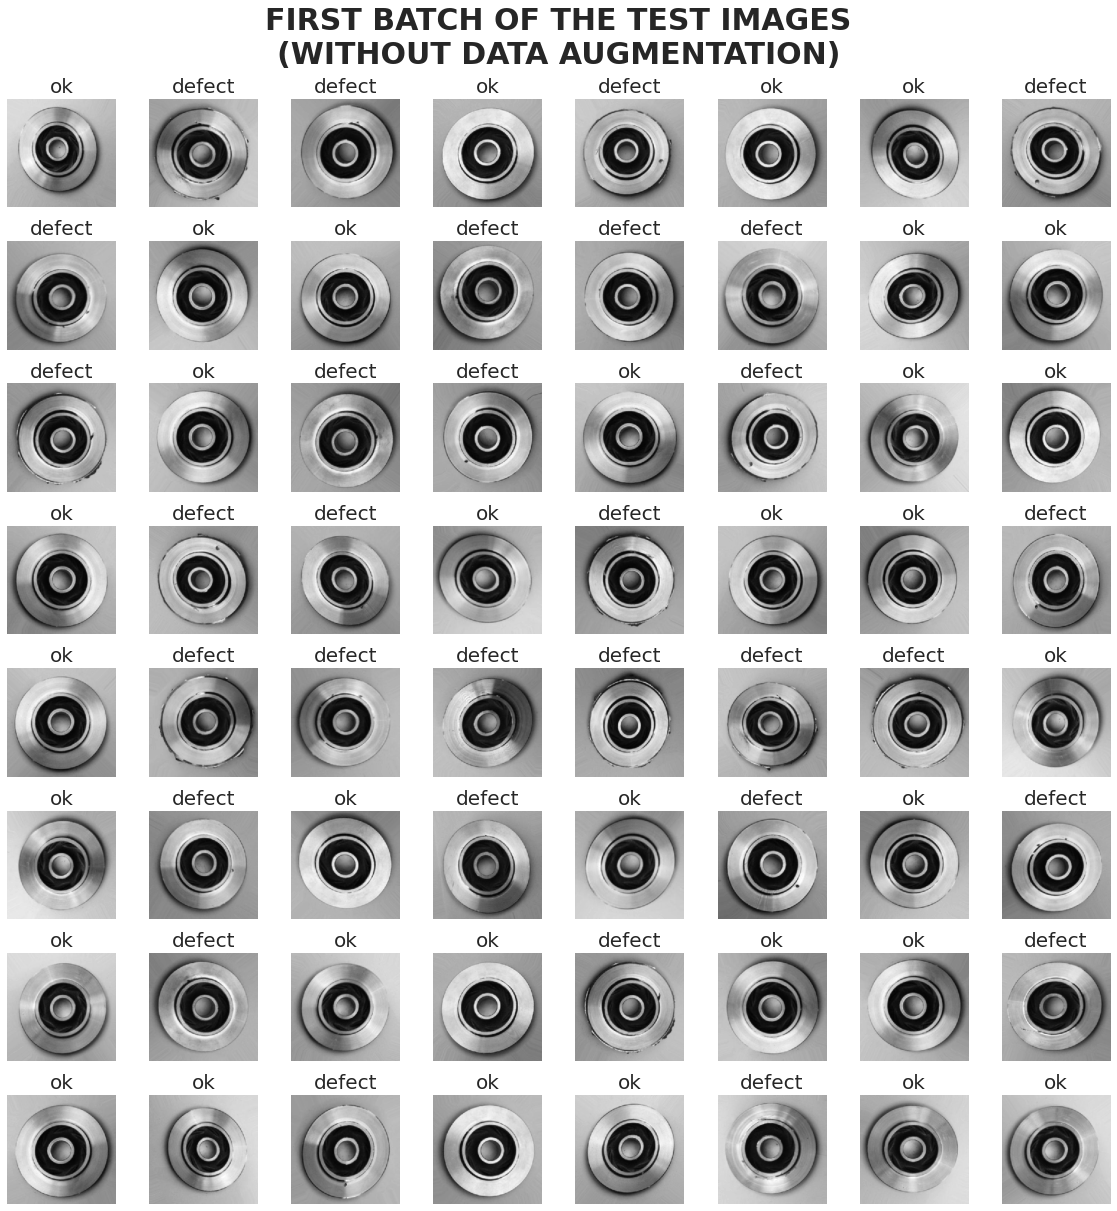

In [12]:
test_images = visualizeImageBatch(test_dataset, "FIRST BATCH OF THE TEST IMAGES\n(WITHOUT DATA AUGMENTATION)")

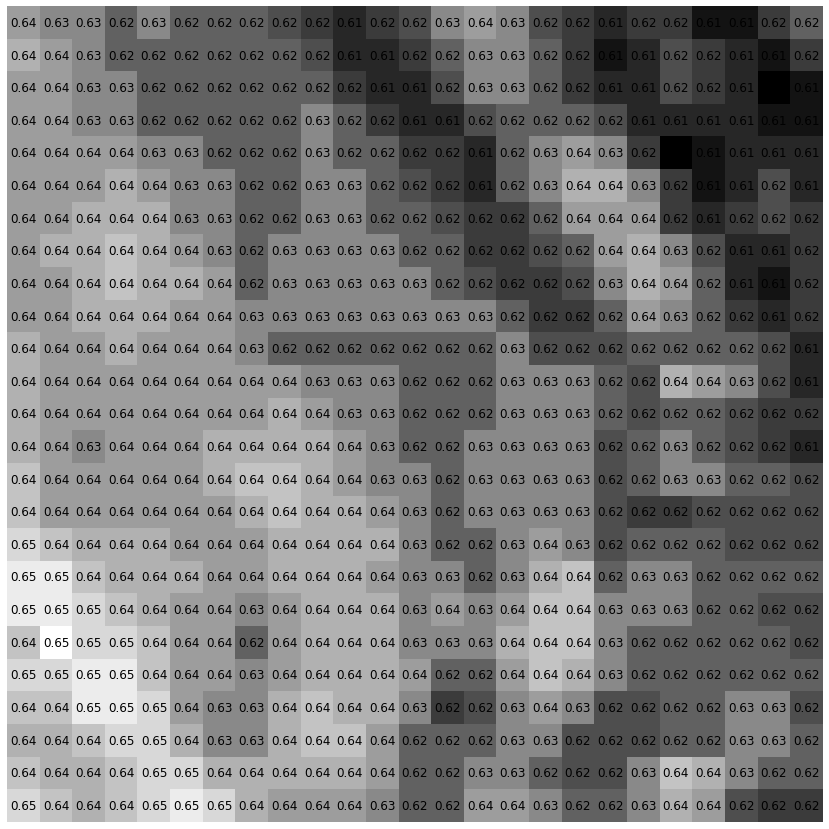

In [13]:
img = np.squeeze(train_images[4])[25:50, 25:50]

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
ax.imshow(img, cmap = "gray")
ax.axis("off")

w, h = img.shape
for x in range(w):
    for y in range(h):
        value = img[x][y]
        ax.annotate("{:.2f}".format(value), xy = (y,x),
                    horizontalalignment = "center",
                    verticalalignment = "center",
                    color = "white" if value < 0.4 else "black")

In [14]:
model = Sequential()
model.add(Conv2D(filters = 64,kernel_size = 3,activation = "relu",input_shape =(225,225,1)))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 32,kernel_size = 3,activation = "relu"))
model.add(MaxPooling2D(pool_size = 2))
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(rate = 0.2))
model.add(Dense(64, activation = "relu"))
model.add(Dropout(rate = 0.2))
model.add(Dense(1, activation = "sigmoid"))
# model.add(Dense(input_dim=(174),activation="relu"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 223, 223, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 93312)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               11944064  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

2022-08-13 05:54:28.848339: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-13 05:54:28.848386: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-13 05:54:28.848414: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-2-50): /proc/driver/nvidia/version does not exist
2022-08-13 05:54:28.848672: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
model.compile(optimizer = "adam",loss = "binary_crossentropy",metrics = ["accuracy"])

In [16]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18146453278878568693
]


In [20]:
STEPS = 5

checkpoint = ModelCheckpoint("model.h5",verbose = 1,save_best_only = True,monitor = "val_loss")

model.fit_generator(generator = train_dataset,
                    validation_data = validation_dataset,
                    steps_per_epoch = STEPS,
                    epochs = 5,
                    validation_steps = STEPS,
                    callbacks = [checkpoint],
                    verbose = 1)

Epoch 1/5
5/5 [==============================] - 10s 1s/step - loss: 0.6944 - accuracy: 0.4911 - val_loss: 0.6926 - val_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 0.69257, saving model to model.h5


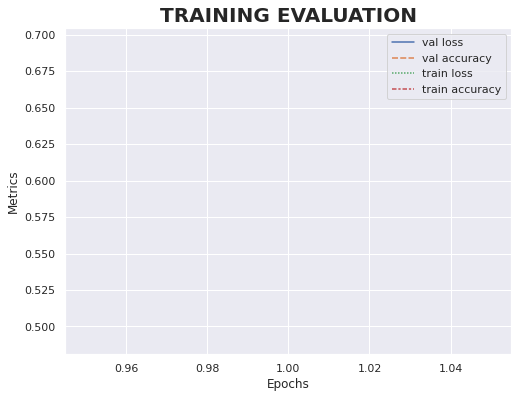

In [21]:
plt.subplots(figsize = (8, 6))
sns.lineplot(data = pd.DataFrame(model.history.history,
                                 index = range(1, 1+len(model.history.epoch))))
plt.title("TRAINING EVALUATION", fontweight = "bold", fontsize = 20)
plt.xlabel("Epochs")
plt.ylabel("Metrics")

plt.legend(labels = ['val loss', 'val accuracy', 'train loss', 'train accuracy'])
plt.show()

In [22]:
best_model = load_model("model.h5")

In [23]:
y_pred_prob = best_model.predict_generator(generator = test_dataset,verbose = 1)

/home/ubuntu/.local/lib/python3.8/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


2/2 [==============================] - 2s 735ms/step


In [24]:
THRESHOLD = 0.5
y_pred_class = (y_pred_prob >= THRESHOLD).reshape(-1,)
y_true_class = test_dataset.classes[test_dataset.index_array]

pd.DataFrame(
    confusion_matrix(y_true_class, y_pred_class),
    index = [["Actual", "Actual"], ["ok", "defect"]],
    columns = [["Predicted", "Predicted"], ["ok", "defect"]],
)

Predicted       
                     ok defect
Actual ok             0     50
       defect         0     50

In [25]:
print(classification_report(y_true_class, y_pred_class, digits = 4))

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        50
           1     0.5000    1.0000    0.6667        50

    accuracy                         0.5000       100
   macro avg     0.2500    0.5000    0.3333       100
weighted avg     0.2500    0.5000    0.3333       100



/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
images, labels = next(iter(test_dataset))
images = images.reshape(BATCH_SIZE, *IMAGE_SIZE)
fig, axes = plt.subplots(4, 4, figsize=(16,16))

for ax, img, label in zip(axes.flat, images, labels):
    ax.imshow(img, cmap = "gray")
    true_label = mapping_class[label]
    
    [[pred_prob]] = best_model.predict(img.reshape(1, *IMAGE_SIZE, -1))
    pred_label = mapping_class[int(pred_prob >= THRESHOLD)]
    
    prob_class = 100*pred_prob if pred_label == "defect" else 100*(1-pred_prob)
    
    ax.set_title(f"TRUE LABEL: {true_label}", fontweight = "bold", fontsize = 18)
    ax.set_xlabel(f"PREDICTED LABEL: {pred_label}\nProb({pred_label}) = {(prob_class):.2f}%",
                 fontweight = "bold", fontsize = 15,
                 color = "blue" if true_label == pred_label else "red")
    
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
fig.suptitle("TRUE VS PREDICTED LABEL FOR 16 RANDOM TEST IMAGES", size = 30, y = 1.03, fontweight = "bold")
plt.show()

ValueError: cannot reshape array of size 1822500 into shape (64,225,225)

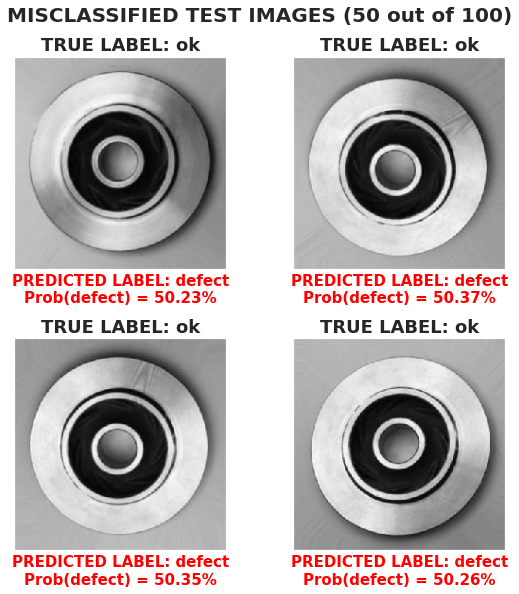

In [27]:
misclassify_pred = np.nonzero(y_pred_class != y_true_class)[0]

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for ax, batch_num, image_num in zip(axes.flat, misclassify_pred // BATCH_SIZE, misclassify_pred % BATCH_SIZE):
    images, labels = test_dataset[batch_num]
    img = images[image_num]
    ax.imshow(img.reshape(*IMAGE_SIZE), cmap = "gray")
    
    true_label = mapping_class[labels[image_num]]
    [[pred_prob]] = best_model.predict(img.reshape(1, *IMAGE_SIZE, -1))
    pred_label = mapping_class[int(pred_prob >= THRESHOLD)]
    
    prob_class = 100*pred_prob if pred_label == "defect" else 100*(1-pred_prob)
    
    ax.set_title(f"TRUE LABEL: {true_label}", fontweight = "bold", fontsize = 18)
    ax.set_xlabel(f"PREDICTED LABEL: {pred_label}\nProb({pred_label}) = {(prob_class):.2f}%",
                 fontweight = "bold", fontsize = 15,
                 color = "blue" if true_label == pred_label else "red")
    
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
fig.suptitle(f"MISCLASSIFIED TEST IMAGES ({len(misclassify_pred)} out of {len(y_true_class)})",
             size = 20, y = 1.03, fontweight = "bold")
plt.show()

In [1]:
def prediction():
    img = request.files['img']
    img.save('img.jpg')
    img = image.load_img("img.jpg", target_size=(225,225,1))
    # mapping_class={'ok':0,'defect':1}
    # best_model='model.h5'
    # true_label = mapping_class[labels[image_num]]
    # [[pred_prob]] = best_model.predict(img.reshape(1, *IMAGE_SIZE, -1))
    # pred_label = mapping_class[int(pred_prob >= THRESHOLD)]
    # prob_class = 100*pred_prob if pred_label == "defect" else 100*(1-pred_prob)

    x=image.img_to_array(img) / 255
    resized_img_np = np.expand_dims(x,axis=0)
    prediction = model.predict(resized_img_np) 
    output={'ok':0,'defect':1} 
    value=np.argmax(prediction)
    print(value)
    lb=list(output.keys())
    print(lb)
    print(lb[value])
    pre=lb[value]
    
    return pre

In [28]:
from flask import Flask, render_template,request
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image

app = Flask(__name__)
model = keras.models.load_model('model.h5')
@app.route('/')
def index():
    return render_template("imgindex.html", name="Tariq")

@app.route('/prediction', methods=["POST"])
def prediction():
    img = request.files['img']
    img.save('img.jpg')
    img = image.load_img("img.jpg", target_size=(225,225,1))
    # mapping_class={'ok':0,'defect':1}
    # best_model='model.h5'
    # true_label = mapping_class[labels[image_num]]
    # [[pred_prob]] = best_model.predict(img.reshape(1, *IMAGE_SIZE, -1))
    # pred_label = mapping_class[int(pred_prob >= THRESHOLD)]
    # prob_class = 100*pred_prob if pred_label == "defect" else 100*(1-pred_prob)

    x=image.img_to_array(img) / 255
    resized_img_np = np.expand_dims(x,axis=0)
    prediction = model.predict(resized_img_np) 
    output={'ok':0,'defect':1} 
    value=np.argmax(prediction)
    print(value)
    lb=list(output.keys())
    print(lb)
    print(lb[value])
    pre=lb[value]
    return render_template("imgprediction.html", data=pre)
    

if __name__ =="__main__":
    app.run(port=5000,debug=True)



 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
 * Restarting with stat
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/.local/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.initialize(argv)
  File "/home/ubuntu/.local/lib/python3.8/site-packages/traitlets/config/application.py", line 88, in inner
    return method(app, *args, **kwargs)
  File "/home/ubuntu/.local/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 666, in initialize
    self.init_sockets()
  File "/home/ubuntu/.local/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 307, in init_sockets
    self.shell_port = self._bind_socket(self.shell_socket, self.shell_port)
  File "/home/ubuntu/.local/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 244, in _bind_socket
    return self._try_bind_socket(s, por

SystemExit: 1

/home/ubuntu/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3377: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [39]:
from __future__ import division, print_function
# coding=utf-8
import sys
import os
import glob
import re
import numpy as np

# Keras
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model
from keras.preprocessing import image

# Flask utils
from flask import Flask, redirect, url_for, request, render_template
from werkzeug.utils import secure_filename
# from gevent.pywsgi import WSGIServer ########

# Define a flask app
app = Flask(__name__)

# Model saved with Keras model.save()
MODEL_PATH = 'model.h5'

# Load your trained model
model = load_model(MODEL_PATH)
# model._make_predict_function()   #############       # Necessary
# print('Model loaded. Start serving...')

# You can also use pretrained model from Keras
# Check https://keras.io/applications/
#from keras.applications.resnet50 import ResNet50
#model = ResNet50(weights='imagenet')
#model.save('')
print('Model loaded. Check http://127.0.0.1:5000/')


def model_predict(img_path, model):
    img = image.load_img(img_path, target_size=(200, 200))

    # Preprocessing the image
    x = image.img_to_array(img)
    # x = np.true_divide(x, 255)
    x = np.expand_dims(x, axis=0)

    # Be careful how your trained model deals with the input
    # otherwise, it won't make correct prediction!
    x = preprocess_input(x, mode='caffe')

    preds = model.predict(x)
    # preds = np.argmax(preds)

    return preds


@app.route('/', methods=['GET'])
def index():
    # Main page
    return render_template('index.html')


@app.route('/predict', methods=['GET', 'POST'])
def upload():
    if request.method == 'POST':
        # Get the file from post request
        f = request.files['file']

        # Save the file to ./uploads
        basepath = os.path.dirname(__file__)
        file_path = os.path.join(
            basepath, 'uploads', secure_filename(f.filename))
        f.save(file_path)

        # Make prediction
        preds = model_predict(file_path, model)

        # Process your result for human
        pred_class = preds.argmax(axis=-1)    # Simple argmax
                   
        # pred_class = decode_predictions(preds, top=1)   # ImageNet Decode
        # result = str(pred_class[0][0][1])               # Convert to string
        
        # pred_class = int(pred_class)
        classes ={0: "d", 1: "o"}

        # return str("The image is classified as: "+str(classes[pred_class]))
        return str(pred_class)

    return None


if __name__ == '__main__':
    app.run(debug=True)


Model loaded. Check http://127.0.0.1:5000/
 * Serving Flask app '__main__' (lazy loading)
 * Environment: development
 * Debug mode: on


OSError: [Errno 98] Address already in use